# Importing Libraries

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt 
import seaborn as sns
import cv2 as cv
from skimage.feature import local_binary_pattern
from skimage import img_as_float,color
from scipy.stats import multivariate_normal
from sklearn.metrics import precision_score,recall_score

# Helper Functions

In [2]:
def normalize_image(img):
    img = (img-np.mean(img))/np.sqrt(np.var(img))
    return img

def min_max_contrast_stretch(image, int_type=False):
    stretched_img = image
    if int_type == False:
        for i in range(3):
            minimum = min([min(p) for p in stretched_img[:, :, i]])
            maximum = max([max(p) for p in stretched_img[:, :, i]])
            for y in range(stretched_img.shape[0]):
                for x in range(stretched_img.shape[1]):
                    stretched_img[y, x, i] = (stretched_img[y, x, i] - minimum) / (maximum - minimum)
    elif int_type == True:
        for i in range(3):
            minimum = min([min(p) for p in stretched_img[:, :, i]])
            maximum = max([max(p) for p in stretched_img[:, :, i]])
            for y in range(stretched_img.shape[0]):
                for x in range(stretched_img.shape[1]):
                    stretched_img[y, x, i] = (stretched_img[y, x, i] - minimum) / (maximum - minimum) * 255
                    
    return stretched_img

# 1) Additional Filters

## 1.1) Create the Gaussian filter using the function shown in Equation 1. Note σ is a hyper-parameter that we set, and depends on the size of your kernel.

### Equation 1: $g(x,y) = \frac{1}{2\pi\sigma^2}e^{-\frac{x^2 + y^2}{2\sigma^2}}$ 

In [3]:
## Shape should be a tuple indicating the size of the desired filter
## Sigma determines the size of the center of the filter
def Gaussian_Filter(shape,sigma):
    r = np.floor(shape[0]/2)
    c = np.floor(shape[1]/2)
    g = lambda x,y : (1/(2*np.pi*(sigma**2)))*np.exp(-((x-r)**2 + (y-c)**2)/(2*(sigma**2)))
    kernel = np.fromfunction(np.vectorize(g),shape)
    return kernel

## 1.2) Create the LoG filter using the function shown in Equation 2.

### Equation 2: $-\frac{1}{\pi \sigma ^4}[1- \frac{x^2 + y^2}{2\sigma ^2}]e^{-\frac{x^2 + y^2}{2\sigma^2}}$

In [4]:
## Shape should be a tuple indicating the size of the desired filter
## Sigma determines the size of the center of the filter
def LoG_Filter(shape,sigma):
    r = np.floor(shape[0]/2)
    c = np.floor(shape[1]/2)
    g = lambda x,y : (-1/(np.pi*(sigma**4))) * (1 - (((x-r)**2 + (y-c)**2)/(2*(sigma**2)))) * np.exp(-((x-r)**2 + (y-c)**2)/(2*(sigma**2)))
    kernel = np.fromfunction(np.vectorize(g),shape)
    return kernel

## 1.3) Create the DoG filter using the function shown in Equation 3. Note K > 1.0 is another hyperparameter used to enforce the constraint that the subtracted Gaussian have a larger variance than the first.

### Equation 3: $g(x,y) = \frac{1}{2\pi\sigma^2}e^{-\frac{x^2 + y^2}{2\sigma^2}} - \frac{1}{2\pi K^2 \sigma^2}e^{-\frac{x^2 + y^2}{2K^2\sigma^2}}$ 

In [5]:
## Shape should be a tuple indicating the size of the desired filter
## Sigma determines the size of the center of the filter
def DoG_Filter(shape,sigma,K=1):
    r = np.floor(shape[0]/2)
    c = np.floor(shape[1]/2)
    g = lambda x,y : (1/(2*np.pi*(sigma**2)))*np.exp(-((x-r)**2 + (y-c)**2)/(2*(sigma**2))) - (1/(2*np.pi*(sigma**2)*K**2))*np.exp(-((x-r)**2 + (y-c)**2)/(2*(sigma**2)*(K**2)))
    kernel = np.fromfunction(np.vectorize(g),shape)
    return kernel

In [6]:
HORIZONTAL_PREWITT = np.fliplr(np.array([
    [-1,0,1],
    [-1,0,1],
    [-1,0,1]
]))
VERTICAL_PREWITT = np.flipud(np.array([
    [-1,-1,-1],
    [0,0,0],
    [1,1,1]
]))
LAPLACIAN = np.array([
    [0,-1,0],
    [-1,4,-1],
    [0,-1,0]
])

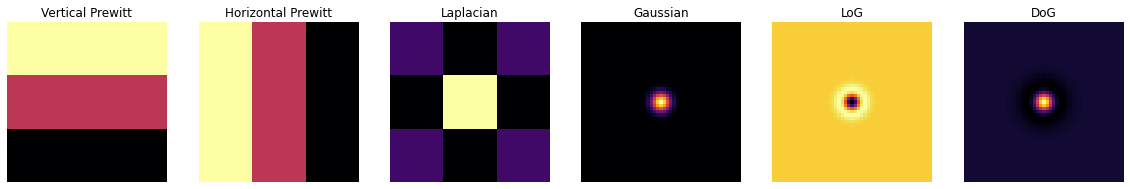

In [7]:

fig,ax = plt.subplots(nrows=1,ncols=6,figsize=(20,20))
plt.subplot(1,6,1),plt.imshow(VERTICAL_PREWITT,cmap="inferno"),plt.title("Vertical Prewitt")
plt.subplot(1,6,2),plt.imshow(HORIZONTAL_PREWITT,cmap="inferno"),plt.title("Horizontal Prewitt")
plt.subplot(1,6,3),plt.imshow(LAPLACIAN,cmap="inferno"),plt.title(f"Laplacian")
plt.subplot(1,6,4),plt.imshow(Gaussian_Filter((49,49),2),cmap="inferno"),plt.title(f"Gaussian")
plt.subplot(1,6,5),plt.imshow(LoG_Filter((49,49),2),cmap="inferno"),plt.title(f"LoG")
plt.subplot(1,6,6),plt.imshow(DoG_Filter((49,49),2,2),cmap="inferno"),plt.title(f"DoG")
np.vectorize(lambda ax:ax.axis('off'))(ax)
plt.show()

## 1.4) Using the above filters on an image

In [8]:
# read in the image 
img_110 =  plt.imread("./image-110.jpg")

### Applying the Gaussian Filter

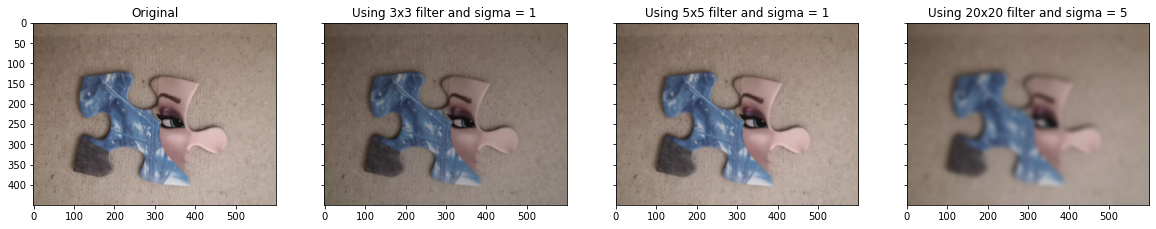

In [9]:
g1 = Gaussian_Filter((3,3),1)
g2 = Gaussian_Filter((5,5),1)
g3 = Gaussian_Filter((20,20),5)
flt_img1 = cv.filter2D(src=img_110, ddepth=-1, kernel=g1)
flt_img2 = cv.filter2D(src=img_110, ddepth=-1, kernel=g2)
flt_img3 = cv.filter2D(src=img_110, ddepth=-1, kernel=g3)

fig,ax = plt.subplots(nrows=1,ncols=4,figsize=(20,20),sharex=True,sharey=True)
plt.subplot(1,4,1),plt.imshow(img_110,cmap="gray"),plt.title("Original")
plt.subplot(1,4,2),plt.imshow(flt_img1,cmap="gray"),plt.title(f"Using 3x3 filter and sigma = 1 ")
plt.subplot(1,4,3),plt.imshow(flt_img2,cmap="gray"),plt.title(f"Using 5x5 filter and sigma = 1")
plt.subplot(1,4,4),plt.imshow(flt_img3,cmap="gray"),plt.title(f"Using 20x20 filter and sigma = 5")
plt.show()

### Applying the LoG Filter

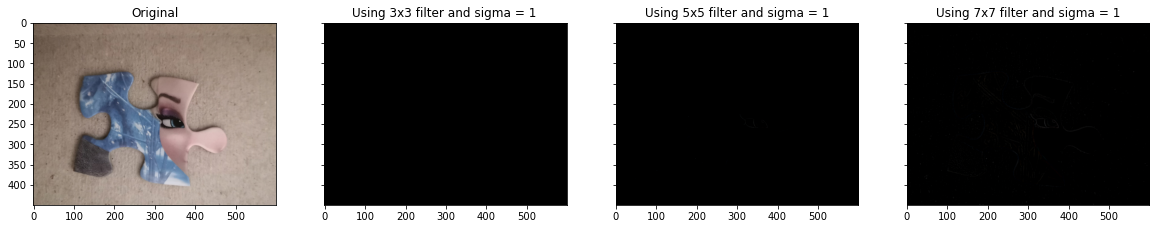

In [10]:
g1 = LoG_Filter((3,3),1)
g2 = LoG_Filter((5,5),1)
g3 = LoG_Filter((7,7),1)
flt_img1 = cv.filter2D(src=img_110, ddepth=-1, kernel=g1)
flt_img2 = cv.filter2D(src=img_110, ddepth=-1, kernel=g2)
flt_img3 = cv.filter2D(src=img_110, ddepth=-1, kernel=g3)

fig,ax = plt.subplots(nrows=1,ncols=4,figsize=(20,20),sharex=True,sharey=True)
plt.subplot(1,4,1),plt.imshow(img_110,cmap="gray"),plt.title("Original")
plt.subplot(1,4,2),plt.imshow(flt_img1,cmap="gray"),plt.title(f"Using 3x3 filter and sigma = 1 ")
plt.subplot(1,4,3),plt.imshow(flt_img2,cmap="gray"),plt.title(f"Using 5x5 filter and sigma = 1")
plt.subplot(1,4,4),plt.imshow(flt_img3,cmap="gray"),plt.title(f"Using 7x7 filter and sigma = 1")
plt.show()

### Applying the DoG Filter

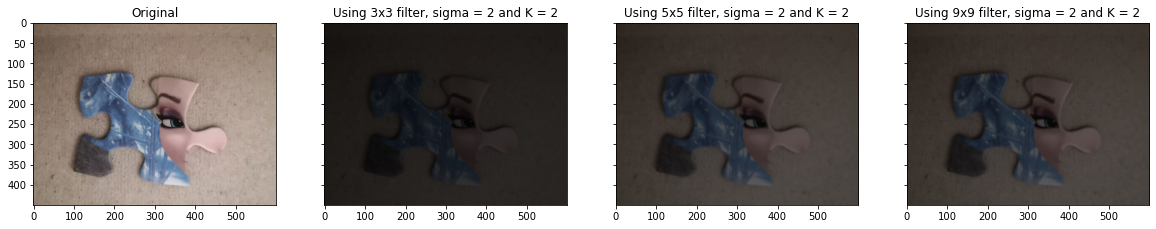

In [11]:
g1 = DoG_Filter((3,3),2,2)
g2 = DoG_Filter((5,5),2,2)
g3 = DoG_Filter((9,9),2,2)
flt_img1 = cv.filter2D(src=img_110, ddepth=-1, kernel=g1)
flt_img2 = cv.filter2D(src=img_110, ddepth=-1, kernel=g2)
flt_img3 = cv.filter2D(src=img_110, ddepth=-1, kernel=g3)

fig,ax = plt.subplots(nrows=1,ncols=4,figsize=(20,20),sharex=True,sharey=True)
plt.subplot(1,4,1),plt.imshow(img_110,cmap="gray"),plt.title("Original")
plt.subplot(1,4,2),plt.imshow(flt_img1,cmap="gray"),plt.title(f"Using 3x3 filter, sigma = 2 and K = 2")
plt.subplot(1,4,3),plt.imshow(flt_img2,cmap="gray"),plt.title(f"Using 5x5 filter, sigma = 2 and K = 2")
plt.subplot(1,4,4),plt.imshow(flt_img3,cmap="gray"),plt.title(f"Using 9x9 filter, sigma = 2 and K = 2")
plt.show()

# 2) Gaussian Edge and Bar Filters - The RFS/MR8 Filter Banks

## 2.1) 2-D Gaussian Filter
Create a function which accepts the three parameters corresponding to the three hyper-parameters of the two-dimensional Gaussian described above (θ, σx, σy), as well as the size of your filter and if the filter is the edge (first derivative) or bar (second derivative) filter. This function should create the filter using the appropriate derivative of g (from Equation (4)) and return this filter.

In [12]:
def create_2d_Gaussian(theta,sigma_x,sigma_y,size,type):
    
    f = lambda x,sigma: (1/(np.sqrt(2*np.pi*sigma)))*np.exp(-(x**2)/(2*(sigma**2)))
    x_prime =  lambda x,y: x*math.cos(theta) -  y*math.sin(theta)
    y_prime =  lambda x,y: x*math.sin(theta) +  y*math.cos(theta)
    center = size//2
    if type == "edge":
        ## we subtract center from x and y so that the (0,0) occurs in the center of the filter
        g = lambda x,y: f(x_prime(x-center,y-center),sigma_x)* f(y_prime(x-center,y-center),sigma_y)*(-y_prime(x-center,y-center)/(sigma_y**2))
        ## We vectorize g since we want g to be applied over each element in the array
        edge_filter = np.fromfunction(np.vectorize(g),(size,size))
        return edge_filter
    elif type =="bar":
        g = lambda x,y: f(x_prime(x-center,y-center),sigma_x)* f(y_prime(x-center,y-center),sigma_y)*(((y_prime(x-center,y-center)**2)-(sigma_y**2))/(sigma_y**2))
        bar_filter = np.fromfunction(np.vectorize(g),(size,size))
        return bar_filter


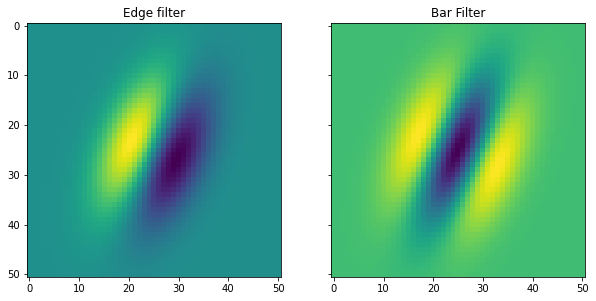

In [13]:
theta = np.pi/8
sigma_x = 10
sigma_y = 5
k = 51
edge_filter = create_2d_Gaussian(theta,sigma_x,sigma_y,k,"edge")
bar_filter = create_2d_Gaussian(theta,sigma_x,sigma_y,k,"bar")
fig,ax = plt.subplots(nrows=1,ncols=2,figsize = (10,10),sharex=True,sharey=True)
plt.subplot(1,2,1) , plt.imshow(edge_filter),plt.title("Edge filter")
plt.subplot(1,2,2) , plt.imshow(bar_filter),plt.title("Bar Filter")
plt.show()


### Applying filters to image

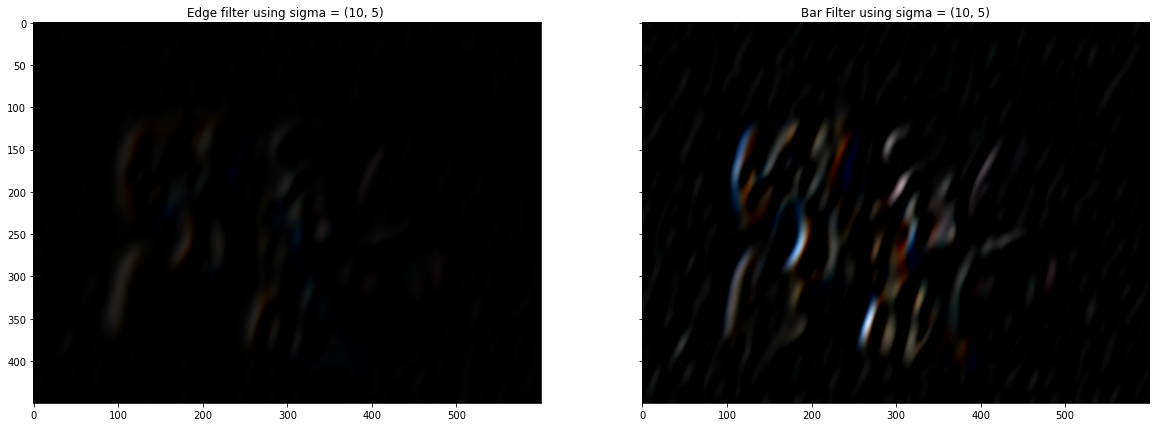

In [14]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize = (20,20),sharex=True,sharey=True)
plt.subplot(1,2,1) , plt.imshow(cv.filter2D(img_110,-1,edge_filter)),plt.title(f"Edge filter using sigma = {sigma_x,sigma_y} ")
plt.subplot(1,2,2) , plt.imshow(cv.filter2D(img_110,-1,bar_filter)),plt.title(f"Bar Filter using sigma = {sigma_x,sigma_y}")
plt.show()

## 2.2) Creating the RFS set
 We will now create the RFS (Root Filter Set) bank from which the rotationally invariant MR8 bank is derived. The 38 filters we use in the RFS bank are a Gaussian and a LoG, both with $σ^2$ = 10 (these filters have rotational symmetry) and rotated sets of Gaussian edge and bar filters. These sets of edge and bar filters will be constructed using the following permutations of hyper-parameters: 
 - $(\sigma_x,\sigma_y) \in [(3,1),(6,2),(12,4)]$
 - $ \theta \in [0, \frac{\pi}{6},\frac{2\pi}{6},\frac{3\pi}{6},\frac{4\pi}{6},\frac{5\pi}{6}]$
 - $ size = (49,49) $ <br>
 Every value for one hyper-parameter needs to be used with every other value for all the other
hyper-parameters. So for example (σx, σy) = (3, 1) needs to be used with all values for θ to
generate a single rotated edge or bar filter set. Since we have 3 (σx, σy) parameters, 6 theta θ
parameters and this process needs to be repeated for the first and second derivatives of g with
respect to y
0
, this results in 3 × 6 × 2 = 36 Gaussian edge and bar filters. Combined with the
Gaussian and LoG filters this gives us our total of 38 RFS filters. An example of our filter bank
can be seen in Figure 2. Apply the RFS filter bank to your image.

In [15]:
variances = [[3,1],[6,2],[12,4]]
thetas = [0, (np.pi/6),(np.pi/3),(np.pi/2),((2*np.pi)/3),((5*np.pi)/6)]
size = 49
def RFS_set(variances = variances,thetas = thetas,size = size):
    edge_filters = []
    bar_filters = []
    for variance in variances:
        
        for theta in thetas:
            edge = create_2d_Gaussian(theta,variance[0],variance[1],type="edge",size = size)
            bar = create_2d_Gaussian(theta,variance[0],variance[1],type="bar",size = size)
            edge_filters.append(np.rot90(edge))
            bar_filters.append(np.rot90(bar))

    gaussians = [Gaussian_Filter((size,size),np.sqrt(10)),LoG_Filter((size,size),math.sqrt(10))]
    return edge_filters,bar_filters,gaussians

In [16]:
rfs_filter_bank = RFS_set()

### Plotting the filters

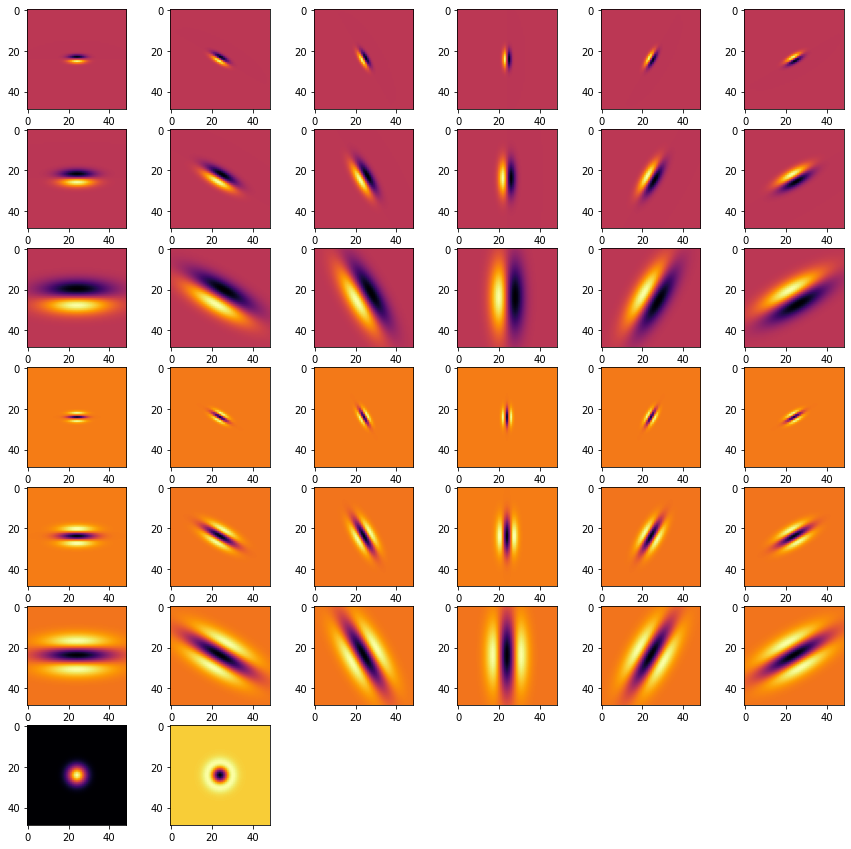

In [17]:
plt.figure(figsize=(15,15))
for i in range (18):
    plt.subplot(7,6,i+1),plt.imshow(rfs_filter_bank[0][i],cmap="inferno"),

for i in range (18):
    plt.subplot(7,6,i+19),plt.imshow(rfs_filter_bank[1][i],cmap="inferno")

for i in range(2):
    plt.subplot(7,6,i+37),plt.imshow(rfs_filter_bank[2][i],cmap="inferno")

### Plotting result of each filter with image

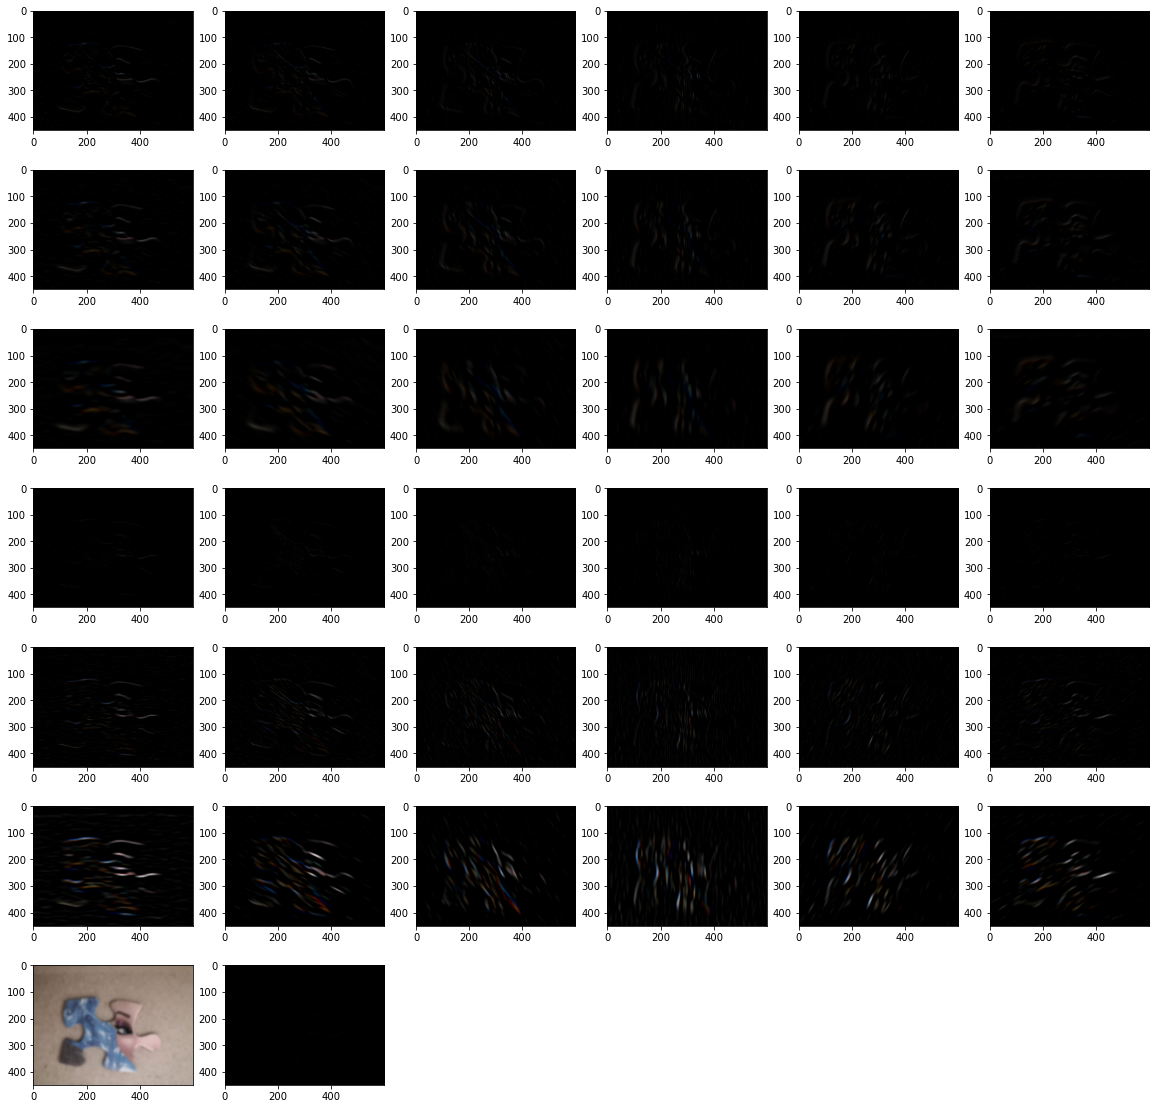

In [18]:
plt.figure(figsize=(20,20))
for i in range (18):
    plt.subplot(7,6,i+1),plt.imshow(cv.filter2D(img_110,-1,rfs_filter_bank[0][i]))

for i in range (18):
    plt.subplot(7,6,i+19),plt.imshow(cv.filter2D(img_110,-1,rfs_filter_bank[1][i]))

for i in range(2):
    plt.subplot(7,6,i+37),plt.imshow(cv.filter2D(img_110,-1,rfs_filter_bank[2][i]))

## 2.3) Creating the MR8 set
 The MR8 rotationally invariant features are constructed from the maximal activations of the
similar but rotated filters in the RFS bank (each row in figure 2). This results in 8 total features
instead of 38 for each pixel after being applied to an image. So for every (σx, σy) of the edge
and bar filters separately, find the maximal θ
∗ value which corresponds to the rotated filter with
the largest activation and keep only this θ’s activation value. Do this for each pixel individually.
Use the RFS hyper-parameters for each pixel, and let αθ be the activation of the current pixel for
the different rotated filters corresponding to θ:
- $(\sigma_x,\sigma_y) \in [(3,1),(6,2),(12,4)]$
- $ \theta^*  = \argmax  \alpha_\theta $
- $ size = (49,49) $ <br>

In [19]:
def get_max_response(matrices,image):

    n = len(matrices)
    convolved_R = [cv.filter2D(image[:,:,0],-1,f) for f in matrices]
    convolved_G = [cv.filter2D(image[:,:,1],-1,f) for f in matrices]
    convolved_B = [cv.filter2D(image[:,:,2],-1,f) for f in matrices]
    t = [convolved_R,convolved_G,convolved_B]
    results = []

    for j in range(3):
        result = t[j][0]
        # result = convolved[0]
        for i in range(n-1):
            ## Compare the rsult with the next matrix
            ## This will return 2d array of True and false values indicating whether or not the value is greater than the value in the other matrix
            next_mat = t[j][i+1]
            # next_mat = convolved[i+1]
            tmp = np.greater_equal(result,next_mat)
            ## The false indices will correlate to indices that have a larger value than result at that index
            idx = np.where(tmp == False)
            ## SO we replace the false indices with the higher values
            result[idx] = next_mat[idx]
        results.append(result)

    final = np.stack((results[0],results[1],results[2]),axis=-1)
    return final

def MR8_set(image,variances = variances,thetas = thetas,size = size):

    rfs = RFS_set(variances,thetas,size)
    edge_results = []
    bar_results = []
    for i in range(0,18,6):
        r1 = get_max_response(rfs[0][i:i+6],image)
        edge_results.append(r1)
    
    for i in range(0,18,6):
        r1 = get_max_response(rfs[1][i:i+6],image)
        bar_results.append(r1)

    gaus = [cv.filter2D(image,-1,f) for f in rfs[2]]
    return edge_results,bar_results,gaus


In [20]:
MR8_filter_bank = MR8_set(img_110)

### Plotting the MR8 filters

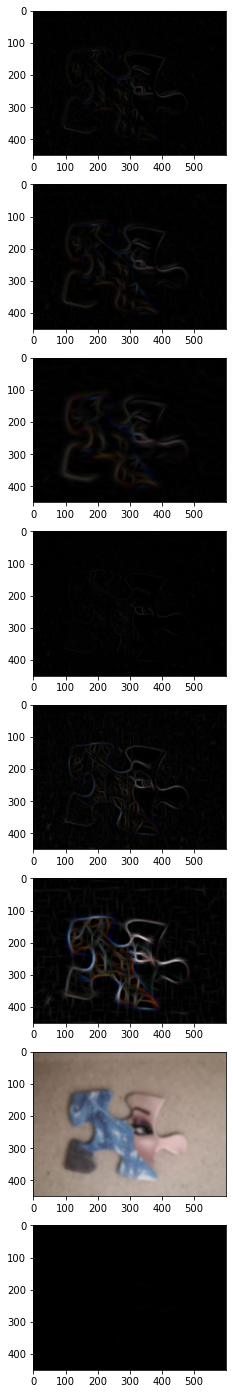

In [21]:
plt.figure(figsize=(25,25))
for i in range (3):
    plt.subplot(8,1,i+1),plt.imshow(MR8_filter_bank[0][i],cmap="inferno"),

for i in range (3):
    plt.subplot(8,1,i+4),plt.imshow(MR8_filter_bank[1][i],cmap="inferno")

for i in range(2):
    plt.subplot(8,1,i+7),plt.imshow(MR8_filter_bank[2][i],cmap="inferno")

# 3) Local Binary Patterns and Haar Filters

## 3.1) Implement the local binary pattern filter and apply it to your training image. Use radius = {4, 8, 16, 24, 32} with 12 points

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


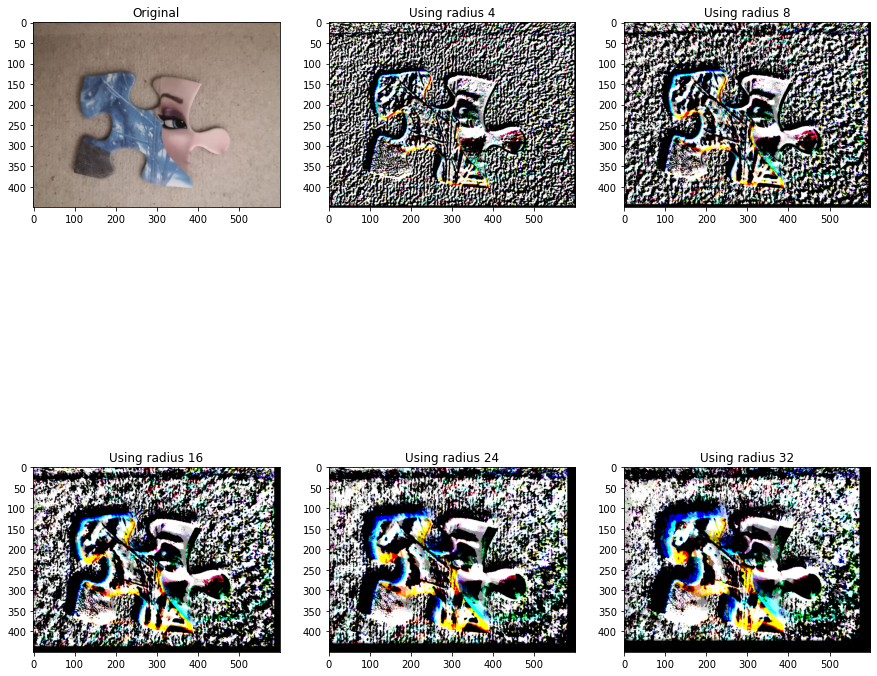

In [22]:
radius = [4,8,16,24,32]
fig,ax = plt.subplots(nrows=2,ncols=3,figsize=(15,15))
plt.subplot(2,3,1), plt.imshow(img_110,cmap="gray"),plt.title("Original")
for i in range(len(radius)):
    r = radius[i]
    lbp1 = local_binary_pattern(img_110[:,:,0], 12, r)
    lbp2 = local_binary_pattern(img_110[:,:,1], 12, r)
    lbp3 = local_binary_pattern(img_110[:,:,2], 12, r)
    lbp = normalize_image(np.stack((lbp1,lbp2,lbp3),axis=-1))
    plt.subplot(2,3,i+2), plt.imshow(lbp,cmap="gray"),plt.title(f"Using radius {r}")

plt.show()

## 3.2) Calculate the three integral images for each channel of your original RGB image.

In [23]:
def integral_image(img):
    r,c = np.shape(img)
    integral =  np.zeros((r,c))
    integral[0,0] = img[0,0]
    # computing the first row of the integral image
    for i in range(1,c):
        integral[0,i] = np.sum(img[0,0:i+1])
        
    # computing the first column of the integral image
    for i in range(1,r):
        integral[i,0] = np.sum(img[0:i+1,0])
    
    for i in range(1,r):
        for j in range(1,c):
            A = integral[i-1,j-1]
            B = integral[i-1,j]
            C = integral[i,j-1]
            D = img[i,j]
            integral[i,j] = C+B-A+D
            
    return integral

In [24]:
R_integral = integral_image(img_110[:,:,0])
G_integral = integral_image(img_110[:,:,1])
B_integral = integral_image(img_110[:,:,2])

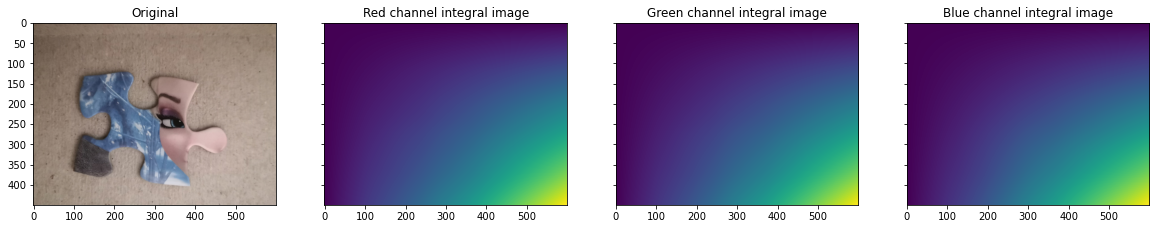

In [25]:
fig,ax = plt.subplots(nrows=1,ncols=4,figsize=(20,20),sharex=True,sharey=True)
plt.subplot(1,4,1),plt.imshow(img_110,cmap="gray"),plt.title("Original")
plt.subplot(1,4,2),plt.imshow(R_integral),plt.title("Red channel integral image")
plt.subplot(1,4,3),plt.imshow(G_integral),plt.title("Green channel integral image")
plt.subplot(1,4,4),plt.imshow(B_integral),plt.title("Blue channel integral image")
plt.show()

## 3.3) Apply a checkered Haar filter like the one shown in Figure 3 to your image using your integral images. So the top left and bottom right quadrants are 1’s and the top right and bottom left quadrants are −1’s in your filter. Use filter sizes = {4, 8, 16}.

In [26]:
def haar_filter(size):
    kernel = np.zeros((size,size))
    
    s = size//2
    
    for i in range(size):
        a = [1,-1]*s
        if(i%2 == 0):
            kernel[i] = a
        else:
            kernel[i] = -1*np.array(a)
    
    return kernel

In [27]:
filter_4 = haar_filter(4)
r_4 = cv.filter2D(src = R_integral,ddepth = -1, kernel = filter_4)
g_4 = cv.filter2D(src = G_integral,ddepth = -1, kernel = filter_4)
b_4 = cv.filter2D(src = B_integral,ddepth = -1, kernel = filter_4)
filter4_result = np.stack((r_4,g_4,b_4),axis=-1)

filter_8 = haar_filter(8)
r_8 = cv.filter2D(src = R_integral,ddepth = -1, kernel = filter_8)
g_8 = cv.filter2D(src = G_integral,ddepth = -1, kernel = filter_8)
b_8 = cv.filter2D(src = B_integral,ddepth = -1, kernel = filter_8)
filter8_result = np.stack((r_8,g_8,b_8),axis=-1)

filter_16 = haar_filter(16)
r_16 = cv.filter2D(src = R_integral,ddepth = -1, kernel = filter_16)
g_16 = cv.filter2D(src = G_integral,ddepth = -1, kernel = filter_16)
b_16 = cv.filter2D(src = B_integral,ddepth = -1, kernel = filter_16)
filter16_result = np.stack((r_16,g_16,b_16),axis=-1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


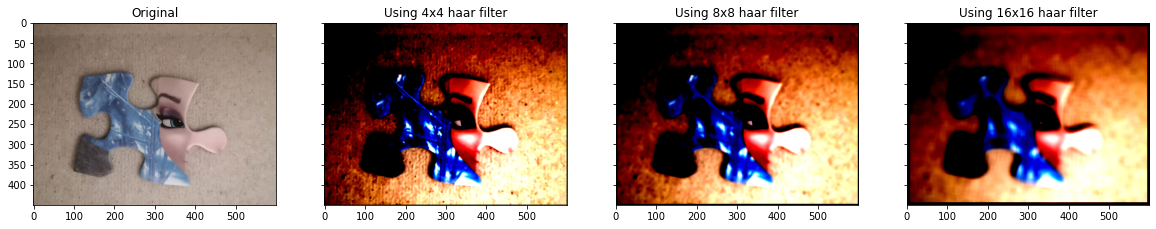

In [28]:
fig,ax = plt.subplots(nrows=1,ncols=4,figsize=(20,20),sharex=True,sharey=True)
plt.subplot(1,4,1),plt.imshow(img_110,cmap="gray"),plt.title("Original")
plt.subplot(1,4,2),plt.imshow(normalize_image(filter4_result),cmap="gray"),plt.title("Using 4x4 haar filter")
plt.subplot(1,4,3),plt.imshow(normalize_image(filter8_result),cmap="gray"),plt.title("Using 8x8 haar filter")
plt.subplot(1,4,4),plt.imshow(normalize_image(filter16_result),cmap="gray"),plt.title("Using 16x16 haar filter")
plt.show()

# 4) Textons and Classification

## 4.1) Apply all of the feature extraction methods above to your image. Using the results, as well as the RGB, HSV, and outputs of the Prewitt and Laplace filters, use the K-Means clustering algorithm to cluster your pixels. Use 4 clusters.

Getting all the features together

In [29]:
def add_img_to_features(img,features,background = None):
    r = np.shape(img)
    img = normalize_image(img)
    if(len(r)==3 and background != None):
        features.append(img[background][:,0].flatten())
        features.append(img[background][:,1].flatten())    
        features.append(img[background][:,2].flatten())
    elif(len(r) == 3 and background == None):
        features.append(img[:,:,0].flatten())
        features.append(img[:,:,1].flatten())
        features.append(img[:,:,2].flatten())
    elif(len(r)==2 and background!= None):
        features.append(img[background].flatten())
    else:
        features.append(img.flatten())

        
def create_feature_vector(image,background= None,HSV_Only= False):
    
    img_hsv = color.rgb2hsv(image)
    if(background != None and not HSV_Only):
        # image = normalize_image(image)
        features = [image[background][:,0].flatten(),image[background][:,1].flatten(),image[background][:,2].flatten(),img_hsv[background][:,0].flatten(),img_hsv[background][:,1].flatten(),img_hsv[background][:,2].flatten()]

    elif(background == None and not HSV_Only):
        # image = normalize_image(image)
        features = [image[:,:,0].flatten(),image[:,:,1].flatten(),image[:,:,2].flatten(),img_hsv[:,:,0].flatten(),img_hsv[:,:,1].flatten(),img_hsv[:,:,2].flatten()]

    elif(background != None and HSV_Only):
        image = img_hsv
        features = [img_hsv[background][:,0].flatten(),img_hsv[background][:,1].flatten(),img_hsv[background][:,2].flatten()]
    
    else:
        image = img_hsv
        features = [img_hsv[:,:,0].flatten(),img_hsv[:,:,1].flatten(),img_hsv[:,:,2].flatten()]
        
        

    # Applying the gaussian filters from section 1
    r = cv.filter2D(image,-1,Gaussian_Filter((49,49),np.sqrt(10)))
    add_img_to_features(r,features,background)
    add_img_to_features(cv.filter2D(image,-1,LAPLACIAN),features,background)
    add_img_to_features(cv.filter2D(image,-1,HORIZONTAL_PREWITT),features,background)
    add_img_to_features(cv.filter2D(image,-1,VERTICAL_PREWITT),features,background)

    #############################################################################################################################################
    # Applying filters from section 2
    ## RFS filter bank
    rfs_filter_bank = RFS_set()
    for f in rfs_filter_bank:
        for filter in f:
            add_img_to_features(cv.filter2D(image,-1,filter),features,background)

    MR8_filter_bank = MR8_set(image)
    for f in MR8_filter_bank:
        for response in f:
            add_img_to_features(response,features,background)

    #############################################################################################################################################
    # Applying section 3 filters
    ## Applying the LBP features
    radius = [4,8,16,24,32]
    for i in range(len(radius)):
        r = radius[i]
        add_img_to_features(local_binary_pattern(image[:,:,0], 12, r),features,background)
        add_img_to_features(local_binary_pattern(image[:,:,1], 12, r),features,background)
        add_img_to_features(local_binary_pattern(image[:,:,2], 12, r),features,background)

    ## Adding the integral images
    r =  integral_image(image[:,:,0])
    g =  integral_image(image[:,:,1])
    b =  integral_image(image[:,:,2])

    add_img_to_features(r,features,background)
    add_img_to_features(g,features,background)
    add_img_to_features(b,features,background)

    # ## Adding Haar filter results
    sizes = [4,8,16]
    for s in sizes:
        f = haar_filter(s)
        r_16 = cv.filter2D(src = r,ddepth = -1, kernel = f)
        g_16 = cv.filter2D(src = g,ddepth = -1, kernel = f)
        b_16 = cv.filter2D(src = b,ddepth = -1, kernel = f)
        add_img_to_features(r_16,features,background)
        add_img_to_features(g_16,features,background)
        add_img_to_features(b_16,features,background)
    features = np.array(features)
    return features


In [30]:
features_training = create_feature_vector(img_110)
print(f"The shape of the training features is : {np.shape(features_training.T)}")

The shape of the training features is : (270000, 183)


In [31]:
def cluster_image(features,shape):
    k = 4
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 1.0)
    c,labels,centers = cv.kmeans(np.float32(features.T),k,None,criteria,10, flags = cv.KMEANS_PP_CENTERS )
    print("CLUSTERING COMPLETED !")
    return labels.reshape(shape)

## 4.2) Replace the pixels of your image with their corresponding centroid from Question 4.1 and display this image. An example of this can be seen in Figure 4.


CLUSTERING COMPLETED !


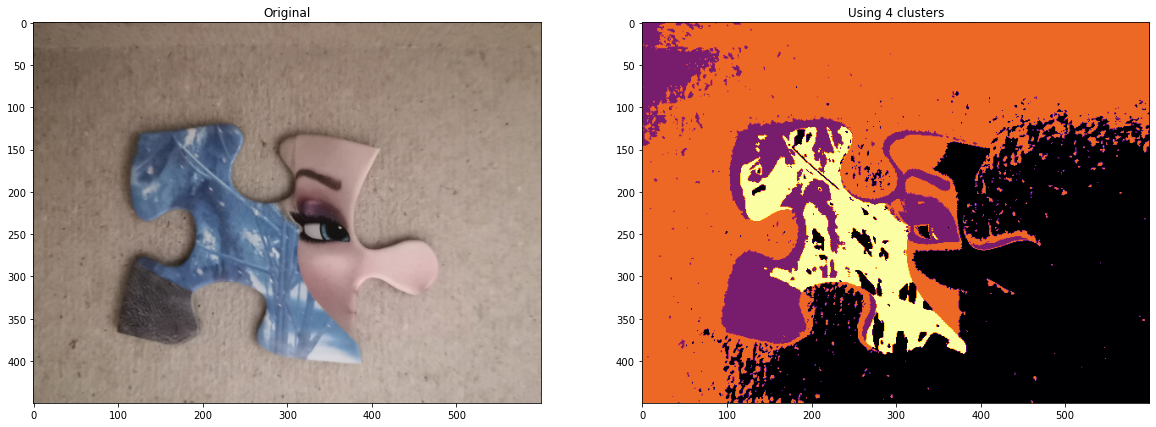

In [32]:
plt.figure(figsize = (20,20))
train_cluster_result = cluster_image(features_training,img_110.shape[:2])
plt.subplot(1,2,1), plt.imshow(img_110,cmap="inferno"),plt.title("Original")
plt.subplot(1,2,2), plt.imshow(train_cluster_result,cmap="inferno"),plt.title("Using 4 clusters")
plt.show()

## 4.3) Train a background classifier on your current set of features (all features mentioned in Question 4.1 including the texton values). Calculate the accuracy of this model.

In [33]:
img_110_mask = cv.cvtColor(plt.imread("./mask-110.png"),cv.COLOR_RGB2GRAY)
bg_indices =  np.where(img_110_mask == 0)
## Adding the textons to the feature set
features_training_bg = np.append(create_feature_vector(img_110,bg_indices),train_cluster_result[bg_indices].flatten().reshape(1,-1),axis=0)

### Getting the mean and covariance matrix

In [34]:
print(f"The shape of the feature vector is: {features_training_bg.shape}")

mean_features = np.mean(features_training_bg,axis=1)
print(f"The shape of the mean vector is: {np.shape(mean_features)}")
# print(mean_features)

covariance_matrix = np.cov(features_training_bg)
print(f"The shape of the covariance matrix is: {np.shape(covariance_matrix)}")
# print(covariance_matrix)

The shape of the feature vector is: (184, 208635)
The shape of the mean vector is: (184,)
The shape of the covariance matrix is: (184, 184)


### Training the model
Fitting a distribution to the mean and covariance of the feature vector

In [35]:
distribution = multivariate_normal( mean=mean_features,cov=covariance_matrix,allow_singular=True)

### The training accuracy

In [36]:
def get_threshold_value(training_pdf_values):
    return np.min(training_pdf_values[np.nonzero(training_pdf_values)])


def evaluate_model(threshold_value,pdf_values,img_shape = np.shape(img_110_mask)):
    background_probabilities = pdf_values>threshold_value

    # Binary Image Prediction
    ## Find the indices that will be classified as background pixels
    background_pixels_indices = np.where(background_probabilities == True)
    ## Create an array of 1's the same size as the mask and flatten it so we can index it with the background pixels above
    binary_result = np.ones(img_shape).flatten()
    ## Set the indices we found to be background pixels as 0.
    binary_result[background_pixels_indices] = 0
    ## reshape array into 2-d so we can plot it as an image
    binary_result = np.reshape(binary_result,img_shape)
    
    return binary_result


def plot_binary_results(original,mask,model):
    fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(20,20))

    plt.subplot(1,3,1),plt.imshow(original), plt.title("Original")
    plt.subplot(1,3,2),plt.imshow(mask,cmap="gray"), plt.title("Mask")
    plt.subplot(1,3,3),plt.imshow(model,cmap="gray"), plt.title("Model mask")
    np.vectorize(lambda ax:ax.axis('off'))(ax)
    plt.show()

def accuracy(predicted,mask,type):
    N = mask.flatten().shape[0]
    diff =  np.abs(predicted-mask)
    acc = 1-((1/N)*(np.sum(diff)))
    precision = precision_score(mask.astype(np.int32).flatten(),predicted.astype(np.int32).flatten())
    recall = recall_score(mask.astype(np.int32).flatten(),predicted.astype(np.int32).flatten())
    acc = np.round(acc*100,3)
    precision = np.round(precision*100,3)
    recall = np.round(recall*100,3)
    print(f"The {type} accuracy is: {acc} %")
    print(f"The {type} precision is: {precision} %")
    print(f"The {type} recall is: {recall} %")

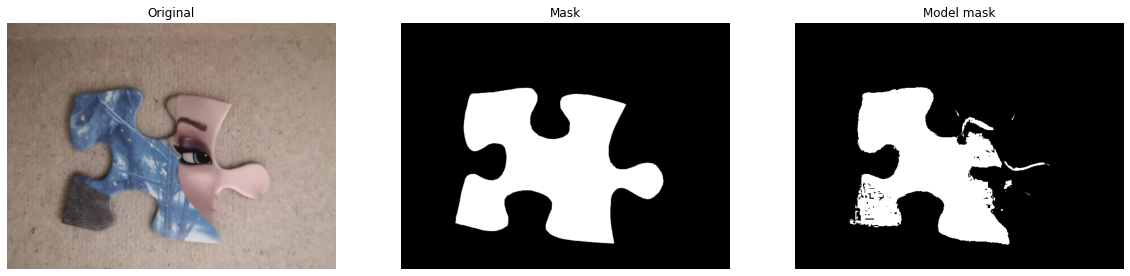

The training accuracy is: 93.0 %
The training precision is: 94.19 %
The training recall is: 72.545 %


In [37]:
training_probabilities = distribution.pdf(np.append(features_training,train_cluster_result.flatten().reshape(1,-1),axis=0).T)
threshold_training = get_threshold_value(training_probabilities)
training_result = evaluate_model(threshold_training,training_probabilities)
plot_binary_results(img_110,img_110_mask,training_result)
accuracy(training_result,img_110_mask,"training")


### Validation accuracy

CLUSTERING COMPLETED !


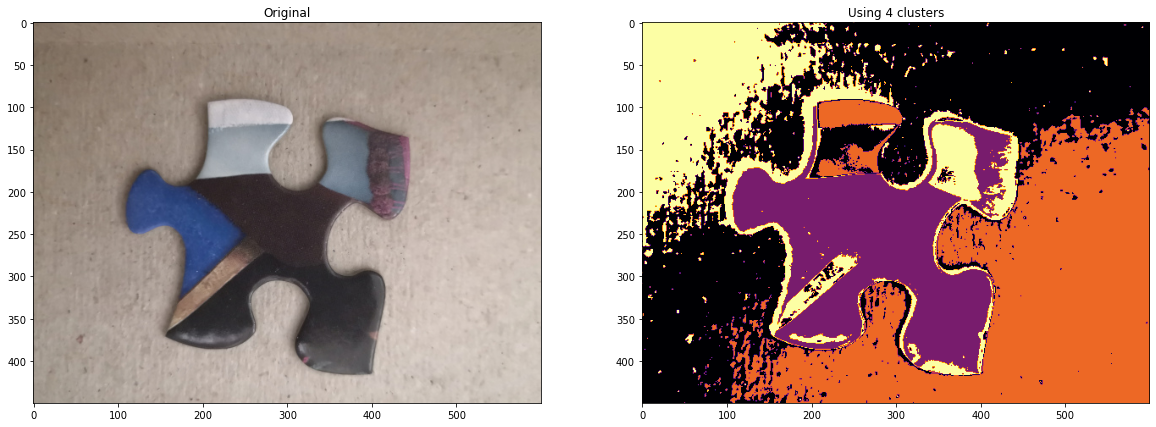

In [38]:
plt.figure(figsize=(20,20))
img_83 = plt.imread("./image-83.jpg")
img_83_mask = cv.cvtColor(plt.imread("./mask-83.png"),cv.COLOR_RGB2GRAY)
validation_features = create_feature_vector(img_83)
validation_cluster = cluster_image(validation_features,img_83.shape[:2])
plt.subplot(1,2,1), plt.imshow(img_83,cmap="inferno"),plt.title("Original")
plt.subplot(1,2,2), plt.imshow(validation_cluster,cmap="inferno"),plt.title("Using 4 clusters")
plt.show()

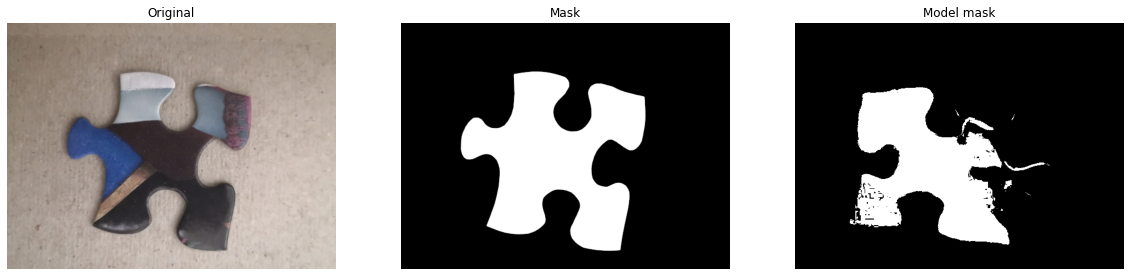

The validation accuracy is: 83.279 %
The validation precision is: 65.639 %
The validation recall is: 50.997 %


In [39]:
validation_probabilities = distribution.pdf(np.append(validation_features,validation_cluster.flatten().reshape(1,-1),axis=0).T)
validation_result = evaluate_model(threshold_training,training_probabilities)
plot_binary_results(img_83,img_83_mask,validation_result)
accuracy(validation_result,img_83_mask,"validation")

## 4.4) Now apply the MR8 feature bank to the HSV pixels and include these features in your model as well. Train another background classifier on these features. Is there a significant improvement in your model’s accuracy?

In [40]:
## Applying MR8 to hsv image
img_110_hsv = color.rgb2hsv(img_110)
MR8 = MR8_set(img_110_hsv)

features_training_bg_hsv = create_feature_vector(img_110,bg_indices).tolist()
features_training_hsv  = np.copy(features_training).tolist()
## Adding new features to feature vector
for f in MR8:
    for r in f:
        ## Adding the background features to train on
        add_img_to_features(r,features_training_bg_hsv,bg_indices)
        ## Adding all the features to see how well model performs on the training data
        add_img_to_features(r,features_training_hsv)

features_training_bg_hsv = np.array(features_training_bg_hsv)
features_training_hsv = np.array(features_training_hsv)

### Training new model

CLUSTERING COMPLETED !


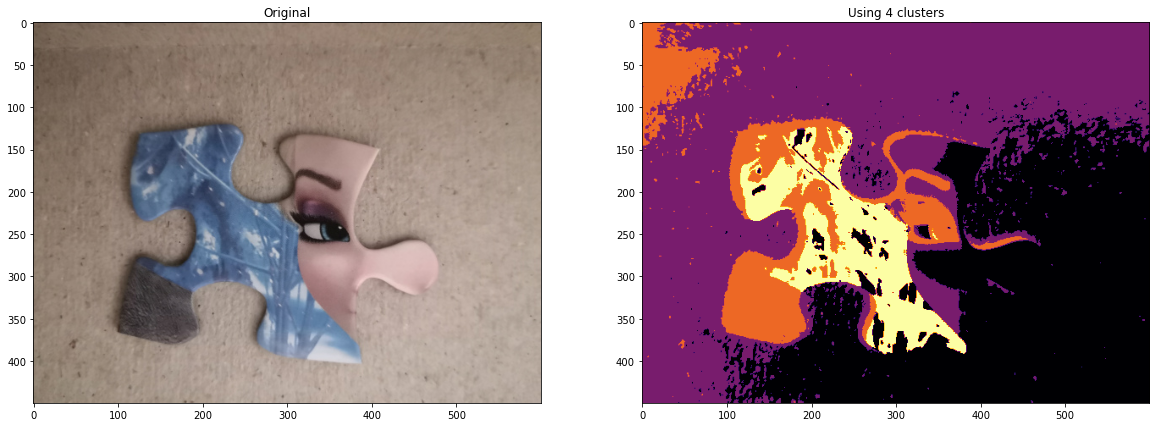

The shape of the feature vector is: (208, 208635)
The shape of the mean vector is: (208,)
The shape of the covariance matrix is: (208, 208)


In [41]:
train_hsv_cluster = cluster_image(features_training_hsv,img_110.shape[:2])
plt.figure(figsize=(20,20))
plt.subplot(1,2,1), plt.imshow(img_110,cmap="inferno"),plt.title("Original")
plt.subplot(1,2,2), plt.imshow(train_hsv_cluster,cmap="inferno"),plt.title("Using 4 clusters")
plt.show()
features_training_bg_hsv =  np.append(features_training_bg_hsv,train_hsv_cluster[bg_indices].flatten().reshape(1,-1),axis=0)
print(f"The shape of the feature vector is: {features_training_bg_hsv.shape}")

mean_features_hsv = np.mean(features_training_bg_hsv,axis=1)
print(f"The shape of the mean vector is: {np.shape(mean_features_hsv)}")
# print(mean_features)

covariance_matrix_hsv = np.cov(features_training_bg_hsv)
print(f"The shape of the covariance matrix is: {np.shape(covariance_matrix_hsv)}")
# print(covariance_matrix)
distribution_hsv = multivariate_normal( mean=mean_features_hsv,cov=covariance_matrix_hsv,allow_singular=True)

### Training accuracy

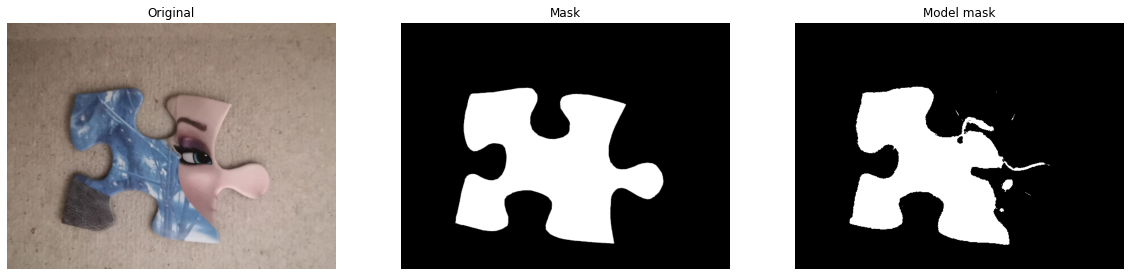

The training accuracy is: 93.819 %
The training precision is: 93.085 %
The training recall is: 77.154 %


In [42]:
training_probabilities_hsv = distribution_hsv.pdf(np.append(features_training_hsv,train_hsv_cluster.flatten().reshape(1,-1),axis=0).T)
threshold_training_hsv = get_threshold_value(training_probabilities_hsv)
training_result_hsv = evaluate_model(threshold_training_hsv,training_probabilities_hsv)
plot_binary_results(img_110,img_110_mask,training_result_hsv)
accuracy(training_result_hsv,img_110_mask,"training")

### Validation Accuracy

CLUSTERING COMPLETED !


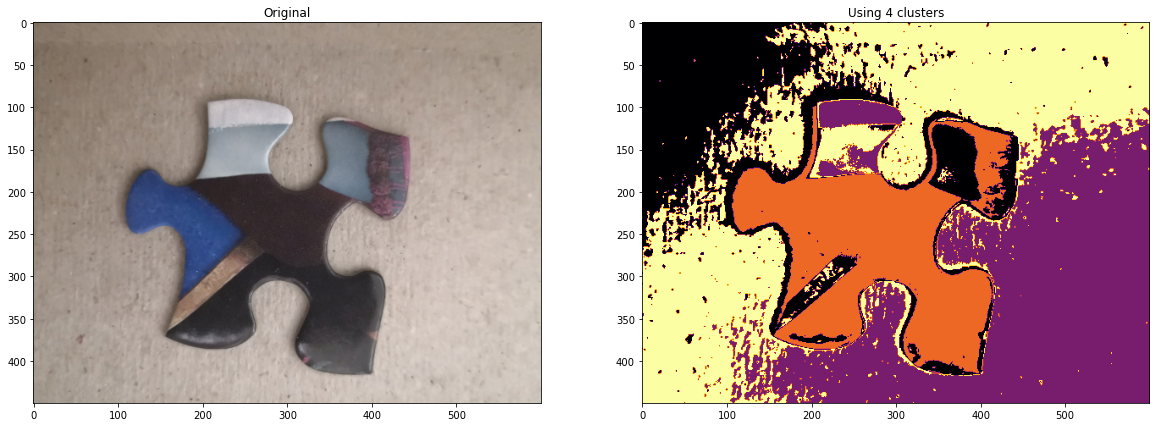

In [43]:
plt.figure(figsize=(20,20))
img_83_hsv = color.rgb2hsv(img_83)
MR8_valid_hsv = MR8_set(img_83_hsv)

validation_features_hsv = create_feature_vector(img_83).tolist()

## Adding new features to feature vector
for f in MR8_valid_hsv:
    for r in f:
        add_img_to_features(r,validation_features_hsv)

validation_features_hsv = np.array(validation_features_hsv)
validation_cluster_hsv = cluster_image(validation_features_hsv,img_83.shape[:2])
plt.subplot(1,2,1), plt.imshow(img_83,cmap="inferno"),plt.title("Original")
plt.subplot(1,2,2), plt.imshow(validation_cluster_hsv,cmap="inferno"),plt.title("Using 4 clusters")
plt.show()

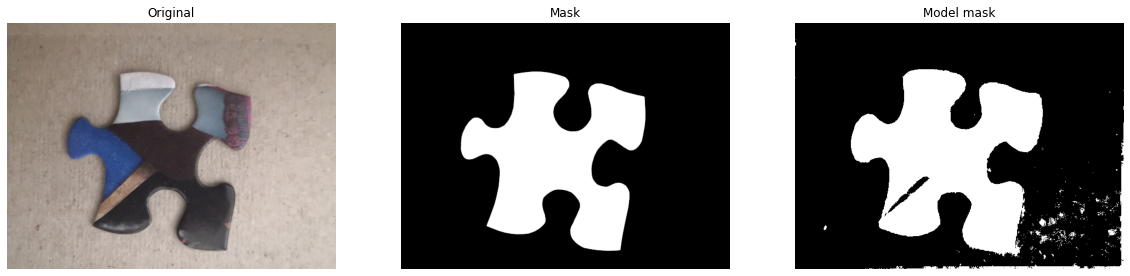

The validation accuracy is: 95.173 %
The validation precision is: 81.204 %
The validation recall is: 98.656 %


In [44]:
validation_features_hsv = np.append(validation_features_hsv,validation_cluster_hsv.flatten().reshape(1,-1),axis=0)
validation_probabilities_hsv = distribution_hsv.pdf(validation_features_hsv.T)

validation_result_hsv = evaluate_model(threshold_training_hsv,validation_probabilities_hsv)
plot_binary_results(img_83,img_83_mask,validation_result_hsv)
accuracy(validation_result_hsv,img_83_mask,"validation")

From the results above, we note the following: <br>
1. Adding the MR8 filter bank of the HSV image to the feature set lead to an increase in training accuracy by approximately 1%.
2. The addition of the HSV MR8 filter bank also added a significant increase on the validation image. This was an approximate 10% increase.
3. The validation recall and precision without the additional MR8 HSV features were 51 % and 65 % respectively. However, the addition of these features lead to a validation recall and precision 98 % and 77 % respectively. This shows that these features enable the model to make more correct predictions for the foreground pixels. 
4. Thus, adding these features improves the models performance on unseen data and in general.

## 4.5) Apply any other adjustments you think may be helpful for your model and report your final accuracy on test data. Remember to tune your hyper-parameters using validation data.

Since the HSV features lead to a major improvement in overall performance, we assume that the features in this colour space are more valuable.
Consequently, we utilise the afore mentioned filters in the HSV colour space, and utilise those as our features.

### Getting the necessary features

In [45]:
HSV_only_features_bg = create_feature_vector(img_110,bg_indices,True)
HSV_only_features = create_feature_vector(img_110,HSV_Only=True)

### Training the model

CLUSTERING COMPLETED !


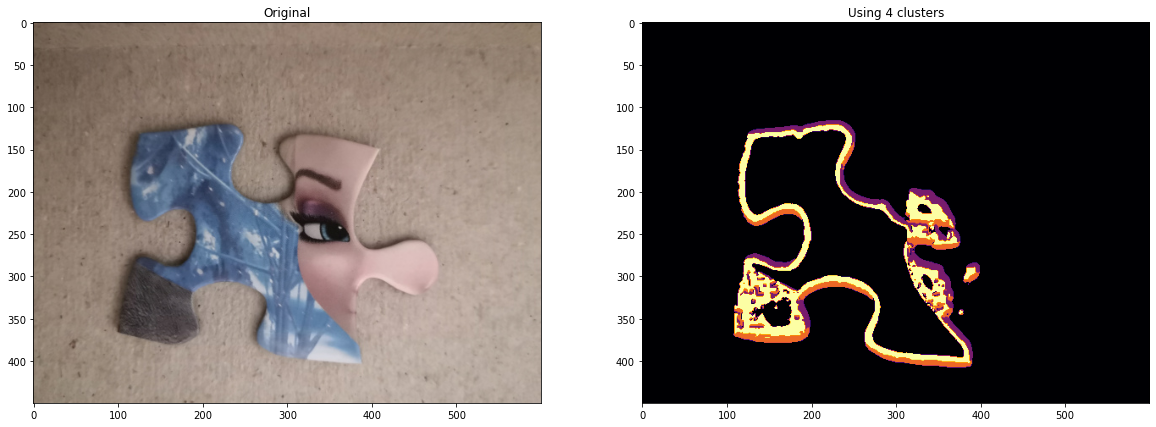

In [46]:
cluster_train_hsv_only = cluster_image(HSV_only_features,img_110.shape[:2])
plt.figure(figsize=(20,20))
plt.subplot(1,2,1), plt.imshow(img_110,cmap="inferno"),plt.title("Original")
plt.subplot(1,2,2), plt.imshow(cluster_train_hsv_only,cmap="inferno"),plt.title("Using 4 clusters")
plt.show()

In [47]:
HSV_only_features_bg =  np.append(HSV_only_features_bg,cluster_train_hsv_only[bg_indices].flatten().reshape(1,-1),axis=0)
print(f"The shape of the feature vector is: {HSV_only_features_bg.shape}")

mean_features_hsv_only = np.mean(HSV_only_features_bg,axis=1)
print(f"The shape of the mean vector is: {np.shape(mean_features_hsv_only)}")
# print(mean_features)

covariance_matrix_hsv_only = np.cov(HSV_only_features_bg)
print(f"The shape of the covariance matrix is: {np.shape(covariance_matrix_hsv_only)}")
# print(covariance_matrix)
distribution_hsv_only = multivariate_normal( mean=mean_features_hsv_only,cov=covariance_matrix_hsv_only,allow_singular=True)

The shape of the feature vector is: (181, 208635)
The shape of the mean vector is: (181,)
The shape of the covariance matrix is: (181, 181)


### Training Accuracy

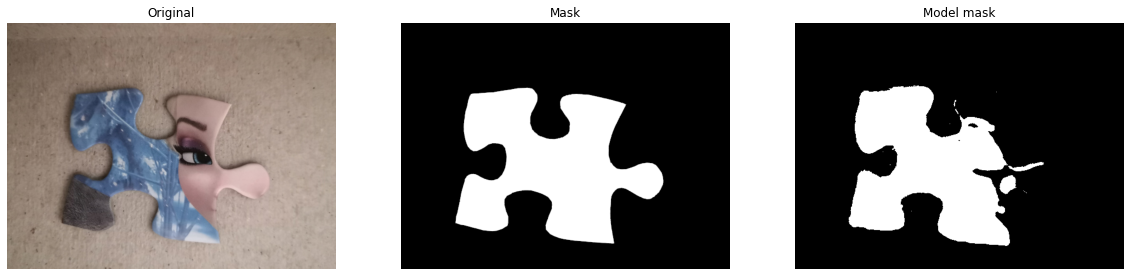

The training accuracy is: 93.985 %
The training precision is: 89.329 %
The training recall is: 81.451 %


In [48]:
training_probabilities_hsv_only = distribution_hsv_only.pdf(np.append(HSV_only_features,train_hsv_cluster.flatten().reshape(1,-1),axis=0).T)
threshold_training_hsv_only = get_threshold_value(training_probabilities_hsv_only)
training_result_hsv_only = evaluate_model(threshold_training_hsv_only,training_probabilities_hsv_only)
plot_binary_results(img_110,img_110_mask,training_result_hsv_only)
accuracy(training_result_hsv_only,img_110_mask,"training")

### Validation Accuracy

CLUSTERING COMPLETED !


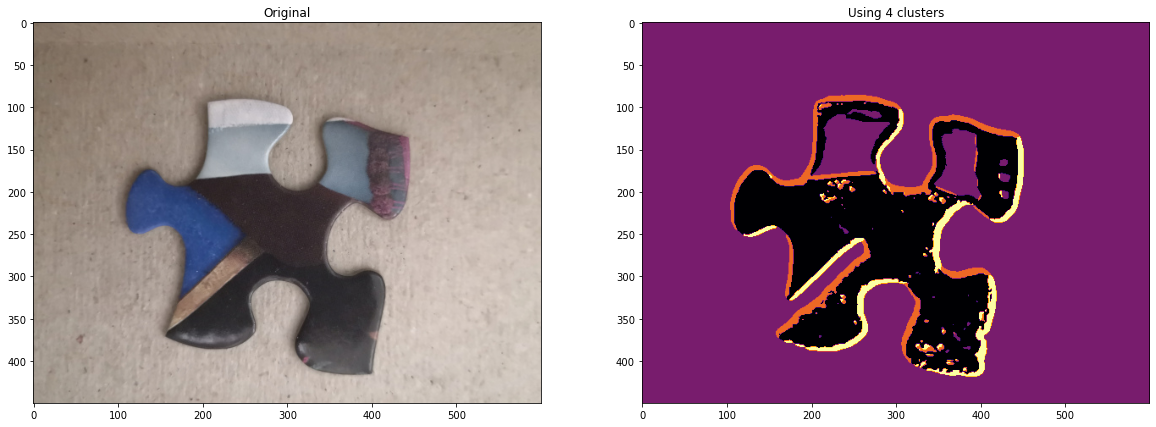

In [64]:
plt.figure(figsize = (20,20))
validation_features_hsv_only = create_feature_vector(img_83,HSV_Only=True)
validation_cluster_hsv_only = cluster_image(validation_features_hsv_only,img_83.shape[:2])
plt.subplot(1,2,1), plt.imshow(img_83,cmap="inferno"),plt.title("Original")
plt.subplot(1,2,2), plt.imshow(validation_cluster_hsv_only,cmap="inferno"),plt.title("Using 4 clusters")
plt.show()

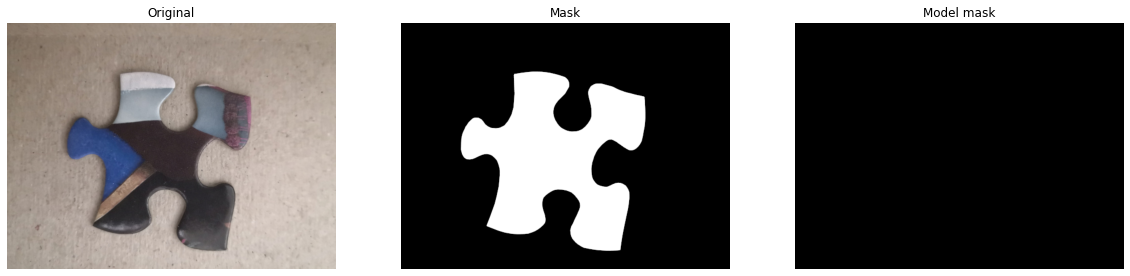

The validation accuracy is: 22.315 %
The validation precision is: 21.833 %
The validation recall is: 100.0 %


In [65]:
validation_features_hsv_only = np.append(validation_features_hsv_only,validation_cluster_hsv_only.flatten().reshape(1,-1),axis=0)
validation_probabilities_hsv_only = distribution_hsv_only.pdf(validation_features_hsv_only.T)

# validation_result_hsv_only = evaluate_model(1,validation_probabilities_hsv_only)
validation_result_hsv_only = evaluate_model(threshold_training_hsv_only,validation_probabilities_hsv_only)
plot_binary_results(img_83,img_83_mask,validation_result_hsv_only)
accuracy(validation_result_hsv_only,img_83_mask,"validation")

### Testing Data

In [66]:
img_35 = plt.imread("./image-35.jpg")
img_35_mask = cv.cvtColor(plt.imread("./mask-35.png"),cv.COLOR_RGB2GRAY)

CLUSTERING COMPLETED !


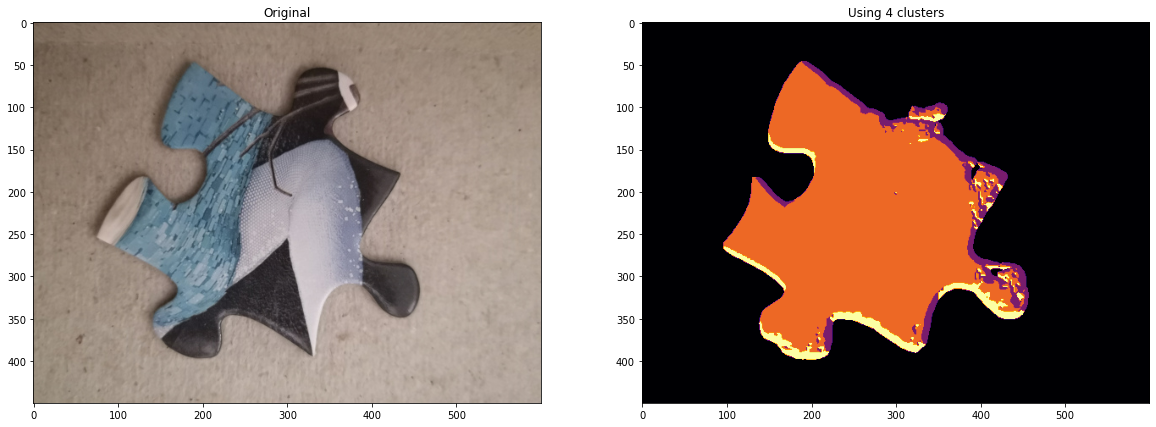

In [69]:
plt.figure(figsize = (20,20))
testing_features_hsv_only = create_feature_vector(img_35,HSV_Only=True)
testing_cluster_hsv_only = cluster_image(testing_features_hsv_only,img_35.shape[:2])
plt.subplot(1,2,1), plt.imshow(img_35,cmap="inferno"),plt.title("Original")
plt.subplot(1,2,2), plt.imshow(testing_cluster_hsv_only,cmap="inferno"),plt.title("Using 4 clusters")
plt.show()

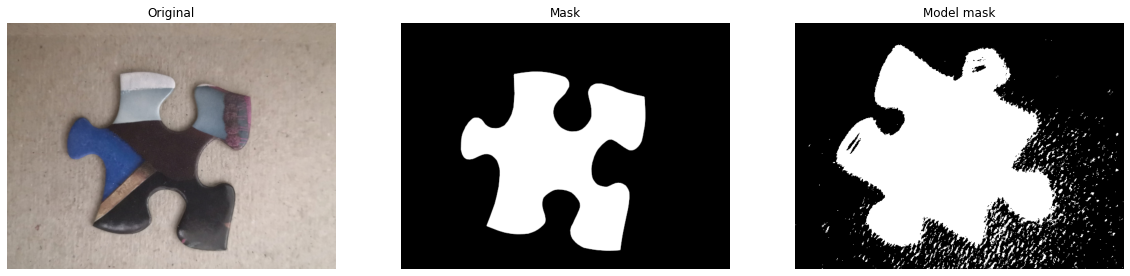

The validation accuracy is: 81.058 %
The validation precision is: 53.681 %
The validation recall is: 88.275 %


In [70]:
testing_features_hsv_only = np.append(testing_features_hsv_only,testing_cluster_hsv_only.flatten().reshape(1,-1),axis=0)
testing_probabilities_hsv_only = distribution_hsv_only.pdf(testing_features_hsv_only.T)

# validation_result_hsv_only = evaluate_model(1,validation_probabilities_hsv_only)
testing_result_hsv_only = evaluate_model(threshold_training_hsv_only,testing_probabilities_hsv_only)
plot_binary_results(img_83,img_83_mask,testing_result_hsv_only)
accuracy(testing_result_hsv_only,img_83_mask,"validation")